In [1]:
import pandas as pd
from scipy.stats import ttest_ind, ks_2samp
import numpy as np

import glob
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'
META_DATA_PATH ='../experiment_meta'
# PLOT_PATH = f'./PLOTS-{date.today().strftime("%b-%d-%Y")}/fixations_grasps/'
PLOT_PATH = './plots_grasp_aligned_fixations_final/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

sns.set(
    context="talk",
    style="ticks",
    palette="deep",
    rc={'font.family':'Microsoft New Tai Lue', 'font.weight':'light'}    
)

In [3]:
shelf_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_ET_shelfData_master.csv')
shelf_df.rename(
    columns={'trialNum':'trial_num', 'subjectID':'subject_id', 'trialID':'trial_id'}, inplace=True)

shelf_df['position_x'] = shelf_df['position_x'].astype(int) + 1
shelf_df['position_y'] = shelf_df['position_y'].astype(int) + 1
shelf_df['shelf_id'] = shelf_df['position_y'].astype(str) + '_' + shelf_df['position_x'].astype(str)
shelf_df['object'] = shelf_df['shape'] + '_' + shelf_df['color']
shelf_df.rename(columns={'position_x': 'pos_x', 'position_y':'pos_y'}, inplace=True)
shelf_df['trial_type'] = (
    shelf_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)
display(shelf_df.head())
display(shelf_df.subject_id.nunique())

,shape,pos_x,pos_y,color,trial_id,subject_id,subjectfileName,trial_num,shelf_id,object,trial_type
0,Cube,5,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_5,Cube_Red,easy
1,Cylinder,1,5,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,5_1,Cylinder_Red,easy
2,Sphere,3,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_3,Sphere_Red,easy
3,Tetraeder,5,4,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,4_5,Tetraeder_Red,easy
4,Cube,1,2,Blue,0.0,2006,../experiment_et_data\subject2006.etd,0,2_1,Cube_Blue,easy


59

22624

1.0

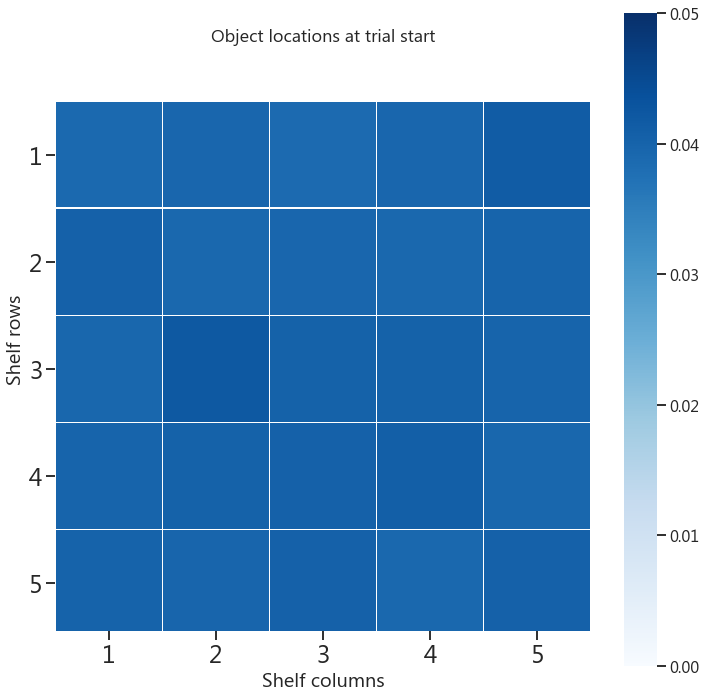

In [4]:
tmpdf = (
    shelf_df
    .groupby(['pos_x', 'pos_y'], as_index=False)
    .shelf_id
    .count()
)
# tmpdf.shelfID = tmpdf.shelfID/tmpdf.shelfID.sum()
tmpdf = tmpdf.pivot(index='pos_y', columns = 'pos_x', values='shelf_id')
# display(tmpdf)
display(tmpdf.sum(axis=1).sum())
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())

# display(tmpdf)
display(tmpdf.sum(axis=1).sum())
_, _ = plt.subplots(1,1,figsize=(12,12))
ax = sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.5, cmap='Blues', square=True)
ax.set_ylim(len(tmpdf)-0.05, -0.5)
plt.yticks(rotation=0, fontsize=25) 
plt.xticks(rotation=0, fontsize=25)
plt.xlabel('Shelf columns', fontsize=20)
plt.ylabel('Shelf rows', fontsize=20)

plt.title('Object locations at trial start')
plt.savefig(PLOT_PATH+'/shelf_randomization.png', quality=90, transparent=True);

## Get shelf centers

In [5]:
files = glob.glob(f'{META_DATA_PATH}/*_pos.csv')
shelf_centers = pd.DataFrame()
for f in files:
    tmpdf = pd.read_csv(f, sep=';')
    tmpdf['object'] = f.split('\\')[1].split('_')[0]
    shelf_centers = pd.concat([shelf_centers, tmpdf], ignore_index=True)

shelf_centers.gridPosition = shelf_centers.gridPosition.str.strip('()')
shelf_centers[['pos_x', 'pos_y']] = shelf_centers.gridPosition.str.split(',', expand=True)
shelf_centers['world position'] = shelf_centers['world position'].str.strip('()')

display(shelf_centers)
shelf_centers[['center_x', 'center_y', 'center_z']] = shelf_centers['world position'].str.split(' ', expand=True)
shelf_centers.center_x = shelf_centers.center_x.str.replace(',', '.').str.strip('.')
shelf_centers.center_y = shelf_centers.center_y.str.replace(',', '.').str.strip('.')
shelf_centers.center_z = shelf_centers.center_z.str.replace(',', '.').str.strip('.')
shelf_centers.drop(columns=['gridPosition', 'world position'], inplace=True)
shelf_centers = shelf_centers.astype({'pos_x':'int32',
                                      'pos_y':'int32',
                                      'center_x':'float64',
                                      'center_y':'float64',
                                      'center_z':'float64'})
# shelf_centers = (shelf_centers
#                  .groupby(['pos_x', 'pos_y'], as_index=False)
#                  .agg({'center_x':'mean',
#                        'center_y':'mean',
#                        'center_z':'mean',
#                       })
#                 )
shelf_centers.pos_x = shelf_centers.pos_x + 1
shelf_centers.pos_y = shelf_centers.pos_y + 1
shelf_centers['shelfID'] = shelf_centers.pos_y.astype(str)+'_'+shelf_centers.pos_x.astype(str)
shelf_centers.object = shelf_centers.object.map({'cube':'Cube',
                                                 'sphere':'Sphere',
                                                 'cylinder':'Cylinder',
                                                 'pyramid':'Tetraeder'})
display(shelf_centers)

,gridPosition,world position,object,pos_x,pos_y
0,"0, 0","-0,882, 1,926, 0,211",cube,0,0
1,"1, 0","-0,436, 1,926, 0,211",cube,1,0
2,"2, 0","0,010, 1,926, 0,211",cube,2,0
3,"3, 0","0,456, 1,926, 0,211",cube,3,0
4,"4, 0","0,902, 1,926, 0,211",cube,4,0
...,...,...,...,...,...
95,"0, 4","-0,882, 0,161, 0,211",sphere,0,4
96,"1, 4","-0,436, 0,161, 0,211",sphere,1,4
97,"2, 4","0,010, 0,161, 0,211",sphere,2,4
98,"3, 4","0,456, 0,161, 0,211",sphere,3,4


,object,pos_x,pos_y,center_x,center_y,center_z,shelfID
0,Cube,1,1,-0.882,1.926,0.211,1_1
1,Cube,2,1,-0.436,1.926,0.211,1_2
2,Cube,3,1,0.010,1.926,0.211,1_3
3,Cube,4,1,0.456,1.926,0.211,1_4
4,Cube,5,1,0.902,1.926,0.211,1_5
...,...,...,...,...,...,...,...
95,Sphere,1,5,-0.882,0.161,0.211,5_1
96,Sphere,2,5,-0.436,0.161,0.211,5_2
97,Sphere,3,5,0.010,0.161,0.211,5_3
98,Sphere,4,5,0.456,0.161,0.211,5_4


## Get shelf location at grasp start and grasp end

In [6]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/06_ET_cleaned.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'is_fixation': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': 'int32', 'trial_num': 'int32', 'trialID': 'int32',
    },
    index_col=False,
)
samples_df.head()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
0,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
1,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
2,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
3,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
4,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN


In [7]:
samples_df.set_index('timestamp_dt', inplace=True)

In [8]:
display(samples_df.pickup_location.isna().mean())
display(samples_df.drop_location.isna().mean())

0.9980650341489805

0.9980650341489805

In [25]:
def get_grasps(sample_df): 
    sample_df = sample_df.sort_values(by='timestamp_dt')
    grasp_times = (
        sample_df.query('grasp_onset_bool == 1')
        [['pickup_location', 'grasp', 'timestamp_dt']]
        .rename(columns=dict(
            timestamp_dt='on_time',
            grasp='current_TO',
        ))
    )
    grasp_times['off_time'] = sample_df.query('grasp_end_bool == 1').timestamp_dt.values
    grasp_times['drop_location'] = sample_df.query('grasp_end_bool == 1').drop_location.values
    grasp_times = grasp_times.sort_values(by='on_time').reset_index(drop=True)

    grasp_times = grasp_times.drop_duplicates(subset = ['pickup_location', 'drop_location', 'current_TO'], keep='first')

    grasp_times = grasp_times.query('pickup_location != drop_location')
    grasp_times['between_grasp_duration'] = (grasp_times['on_time'].shift(-1) 
                                             - grasp_times['on_time'])/np.timedelta64(1, 's')
    
    grasp_times['planning_duration'] = (grasp_times['on_time'] 
                                        - grasp_times['off_time'].shift(1))/np.timedelta64(1, 's')
    
    grasp_times['execution_duration'] = (grasp_times['off_time'] 
                                        - grasp_times['on_time'])/np.timedelta64(1, 's')
    
    grasp_times[['pickup_x','pickup_y']] = grasp_times.pickup_location.str.split('_', expand=True)
    grasp_times[['drop_x','drop_y']] = grasp_times.drop_location.str.split('_', expand=True)
    grasp_times['offset_x'] = grasp_times.drop_x.astype(int) - grasp_times.pickup_x.astype(int)
    grasp_times['offset_y'] = grasp_times.drop_y.astype(int) - grasp_times.pickup_y.astype(int)
    grasp_times['grasp_num'] = grasp_times.index
    
    return grasp_times.set_index('grasp_num')

grp_cols = ['subject_id', 'trial_type', 'trial_num']
grasp_df = (
    samples_df
    .reset_index()
#         .query('subject_id == @subjects')
    .groupby(grp_cols)
    .apply(get_grasps)        
)
# df.reset_index(level=2, drop=True)

display(grasp_df.head())

pickup_location       current_TO  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                     2_1  Tetraeder_Green   
                                1                     2_2      Cube_Yellow   
                                2                     1_4     Sphere_Green   
                                3                     2_4  Cylinder_Yellow   
                                4                     2_5         Cube_Red   

                                                                on_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:05.835639477   
                                1         1970-01-01 00:00:07.633999825   
                                2         1970-01-01 00:00:12.176501274   
                                3         1970-01-01 00:00:15.264882088   
                                4         1970-01-01 00:00:17.475528717   

                                                               off_time  \
subject_id trial_type trial_num grasp_num                                 
2006.0     easy       5.0       0         1970-01-01 00:00:06.802226543   
                                1         1970-01-01 00:00:10.744694710   
                                2         1970-01-01 00:00:13.243731499   
                                3         1970-01-01 00:00:16.397928238   
                                4         1970-01-01 00:00:19.519012451   

                                          drop_location  \
subject_id trial_type trial_num grasp_num                 
2006.0     easy       5.0       0                   1_1   
                                1                   1_3   
                                2                   2_2   
                                3                   1_4   
                                4                   2_3   

                                           between_grasp_duration  \
subject_id trial_type trial_num grasp_num                           
2006.0     easy       5.0       0                        1.798360   
                                1                        4.542501   
                                2                        3.088381   
                                3                        2.210647   
                                4                        3.331923   

                                           planning_duration  \
subject_id trial_type trial_num grasp_num                      
2006.0     easy       5.0       0                        NaN   
                                1                   0.831773   
                                2                   1.431807   
                                3                   2.021151   
                                4                   1.077600   

                                           execution_duration pickup_x  \
subject_id trial_type trial_num grasp_num                                
2006.0     easy       5.0       0                    0.966587        2   
                                1                    3.110695        2   
                                2                    1.067230        1   
                                3                    1.133046        2   
                                4                    2.043484        2   

                                          pickup_y drop_x drop_y  offset_x  \
subject_id trial_type trial_num grasp_num                                    
2006.0     easy       5.0       0                1      1      1        -1   
                                1                2      1      3        -1   
                                2                4      2      2         1   
                                3                4      1      4        -1   
                                4                5      2      3         0   

                              

In [10]:
display(grasp_df.shape)

(12266, 13)

In [11]:
(
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_type'])
    .trial_num
    .nunique()
    .reset_index()
    .groupby('trial_type')
    .trial_num
    .sum()
)

trial_type
easy    592
hard    404
Name: trial_num, dtype: int64

In [12]:
(
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_type'])
    .grasp_num
    .nunique()
    .reset_index()
    .groupby('trial_type')
    .grasp_num
    .sum()
)

trial_type
easy     715
hard    1299
Name: grasp_num, dtype: int64

In [13]:
model_df = pd.DataFrame()
files = glob.glob('shelf_model/collected_depths/task*.pickle')
print(files)
for idx, f in enumerate(files):
    tmpdf = pd.DataFrame()
    with open(f, 'rb') as handle:
        tmp = pickle.load(handle)
    
    if idx == 0:
        tmpdf['num_grasp'] = pd.Series([t[1] for t in tmp])
    else:
        tmpdf['num_grasp'] = pd.Series([t for t in tmp])
        
    
    tmpdf['trial_type'] = f
    print(tmpdf.shape[0])
    model_df = pd.concat([model_df, tmpdf], ignore_index=True)

model_df.trial_type = model_df.trial_type.str.split('\\', expand=True)[1].str.split('.', expand=True)[0]
model_df.trial_type = model_df.trial_type.map({'task1':'easy', 'task2':'hard', 'task3':'hard'})
model_df['subject_id'] = 'model_sub'
model_df['trial_num'] = 'model_trial'
model_df['type'] = 'optimal'
display(model_df)

['shelf_model/collected_depths\\task1.pickle', 'shelf_model/collected_depths\\task2.pickle', 'shelf_model/collected_depths\\task3.pickle']
4008
3608
2937


,num_grasp,trial_type,subject_id,trial_num,type
0,9,easy,model_sub,model_trial,optimal
1,8,easy,model_sub,model_trial,optimal
2,10,easy,model_sub,model_trial,optimal
3,13,easy,model_sub,model_trial,optimal
4,8,easy,model_sub,model_trial,optimal
...,...,...,...,...,...
10548,9,hard,model_sub,model_trial,optimal
10549,9,hard,model_sub,model_trial,optimal
10550,11,hard,model_sub,model_trial,optimal
10551,13,hard,model_sub,model_trial,optimal


In [14]:
model_df.groupby('trial_type').num_grasp.describe()

,count,mean,std,min,25%,50%,75%,max
trial_type,,,,,,,,
easy,4008.0,9.423403,1.488202,4.0,8.0,9.0,10.0,16.0
hard,6545.0,11.242934,2.786015,3.0,9.0,11.0,13.0,23.0


## Difference between human and depth first search model

In [15]:
sns.color_palette('muted', 10)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

count       mean       std        min        25%  \
trial_type type                                                         
easy       human      48.0  10.223694  1.996402   7.333333   8.741071   
           optimal  4008.0   9.423403  1.488202   4.000000   8.000000   
hard       human      48.0  15.520924  2.595219  10.000000  13.593750   
           optimal  6545.0  11.242934  2.786015   3.000000   9.000000   

                        50%        75%   max  
trial_type type                               
easy       human    10.0000  11.604167  16.8  
           optimal   9.0000  10.000000  16.0  
hard       human    15.5625  17.083333  20.9  
           optimal  11.0000  13.000000  23.0

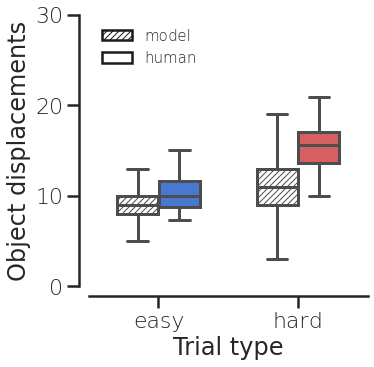

In [15]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

scpt = sns.color_palette('muted', 10)
tmpdf = (
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_num','trial_type',], as_index=False)
    .grasp_num
    .count()
    .rename(columns = {'grasp_num':'num_grasp'})
)

tmpdf = (
    tmpdf
    .groupby(['subject_id','trial_type',], as_index=False)
    .num_grasp
    .mean()
    .reset_index()
)

tmpdf['type'] = 'human'

tmpdf = pd.concat([model_df,tmpdf])

tmpdf = tmpdf.query('num_grasp >=3 ')

display(tmpdf.groupby(['trial_type', 'type']).num_grasp.describe())
_, ax = plt.subplots(1,1, figsize=(5,5))

ax = sns.boxplot(
    data=tmpdf,
    x='trial_type',
    y='num_grasp',
    hue='type',
    palette=['white', 'grey'],
    order=['easy', 'hard'],
    linewidth=3,
    fliersize=0,
    dodge=0.4,
    width=0.6
)

mybox = ax.artists[0]
mybox.set_facecolor('white')
mybox.set_hatch('////')

mybox = ax.artists[1]
mybox.set_facecolor(scpt[0])

mybox = ax.artists[2]
mybox.set_facecolor('white')
mybox.set_hatch('////')

mybox = ax.artists[3]
mybox.set_facecolor(scpt[3])
ax.set(
    ylim=(0,30),
    yticks=np.arange(0,31, 10)
)
# ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.xticks(rotation=90, fontsize=15)
ax.set_ylabel('Object displacements')
ax.set_xlabel('Trial type')
l1 = mpatches.Patch(edgecolor='k',lw=2.5, facecolor='white', hatch='////', label='model')
l2= mpatches.Patch(edgecolor='k', lw=2.5, facecolor='white', hatch='', label='human')

ax.legend(handles=[l1,l2], loc='upper left', frameon=False, fontsize=15, ncol=1)
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/grasps.pdf', quality=90, bbox_inches='tight')

In [16]:
ttest_ind(
    tmpdf.query('trial_type=="easy" and type=="human"').num_grasp, 
    tmpdf.query('trial_type=="easy" and type=="optimal"').num_grasp,
)

Ttest_indResult(statistic=3.686529870903847, pvalue=0.00023030737203635473)

In [17]:
ttest_ind(
    tmpdf.query('trial_type=="hard" and type=="human"').num_grasp, 
    tmpdf.query('trial_type=="hard" and type=="optimal"').num_grasp,
)

Ttest_indResult(statistic=10.604623073169797, pvalue=4.5958289327592876e-26)

In [19]:
ttest_ind(
    tmpdf.query('trial_type=="hard" and type=="human"').num_grasp, 
    tmpdf.query('trial_type=="easy" and type=="human"').num_grasp,
)

Ttest_indResult(statistic=11.208725136992046, pvalue=5.118958390090387e-19)

## Difference in Trial Duration between easy and hard tasks

,count,mean,std,min,25%,50%,75%,max
trial_type,,,,,,,,
easy,48.0,54.124842,13.337679,31.367656,45.805188,52.378323,61.613419,107.615322
hard,48.0,111.570486,36.927735,44.913260,86.295169,107.440002,132.892653,215.767296


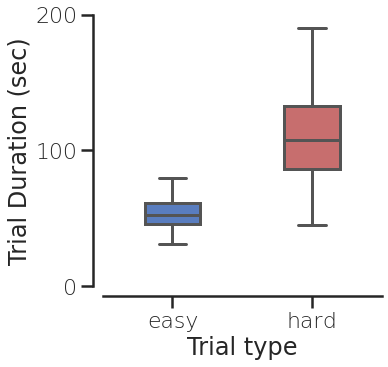

In [21]:
# sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
#         rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})
trial_df = (
    samples_df
#     .set_index('timestamp_dt')
    .groupby(['subject_id','trial_type', 'trial_num'])
    .apply(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's'))
    .rename('trial_duration')
    .reset_index()
)

tmpdf = (
    trial_df
#     .set_index('timestamp_dt')
    .groupby(['subject_id','trial_type',])
    .trial_duration
    .mean()
    .reset_index()
)

display(tmpdf.groupby('trial_type').trial_duration.describe())

_, ax = plt.subplots(1,1,figsize=(5,5))
sns.boxplot(
    data=tmpdf, 
    x='trial_type', 
    y='trial_duration', 
    palette = ['b', 'r'],
    order = ['easy', 'hard'],
    linewidth=3,
    fliersize=0,
    width=0.4,
)

ax.set(
    ylim=(0,200),
    yticks=np.arange(0,301, 100)
)
# ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('Trial Duration (sec)')
plt.xlabel('Trial type')
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/TrialDuration.pdf', quality=90, bbox_inches='tight')

In [22]:
ttest_ind(tmpdf.loc[tmpdf.trial_type=='easy', 'trial_duration'], tmpdf.loc[tmpdf.trial_type=='hard', 'trial_duration'] )

Ttest_indResult(statistic=-10.13675002451793, pvalue=9.416072007203579e-17)

## Difference in duration of planning and execution epochs

,execution_duration,planning_duration
count,48.000000,48.000000
mean,1.646421,1.969787
std,0.305261,0.912628
min,1.121557,0.888393
25%,1.442051,1.339605
50%,1.620358,1.662566
75%,1.797664,2.347112
max,2.936997,5.509247


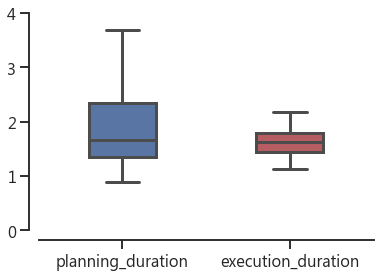

In [57]:
t = (
    grasp_df
    .reset_index()
    .groupby(['subject_id', 'trial_num'])
    .agg({
        'execution_duration':np.median,
        'planning_duration':np.median
    })
    .reset_index()
    .groupby('subject_id')
    .agg({
        'execution_duration':np.mean,
        'planning_duration':np.mean
    })
)

display(t.describe())
ax = sns.boxplot(data=t, order=['planning_duration', 'execution_duration'], palette = ['b', 'r'],
    linewidth=3,
    fliersize=0,
    width=0.4,)

ax.set(
    ylim=(0,4),
    yticks=np.arange(0, 4.5, 1)
)
# ax.yaxis.set_minor_locator(AutoMinorLocator())
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/plan_exe_duration.pdf', quality=90, bbox_inches='tight')

## Spatial bias in pickup and dropping off objects

pickup_x,1,2,3,4,5
pickup_y,,,,,
1,0.020327,0.025658,0.031989,0.041486,0.048817
2,0.027491,0.029490,0.033322,0.036821,0.047151
3,0.034489,0.037321,0.043486,0.040820,0.047151
4,0.036321,0.042153,0.041153,0.037654,0.048151
5,0.049317,0.050150,0.049484,0.049317,0.050483


pickup_x,1,2,3,4,5
pickup_y,,,,,
1,0.015645,0.032727,0.038793,0.038633,0.040230
2,0.027618,0.034323,0.044221,0.041347,0.042784
3,0.034163,0.043263,0.045498,0.043103,0.044540
4,0.036398,0.046616,0.049010,0.042305,0.040230
5,0.035441,0.048052,0.051405,0.041347,0.042305


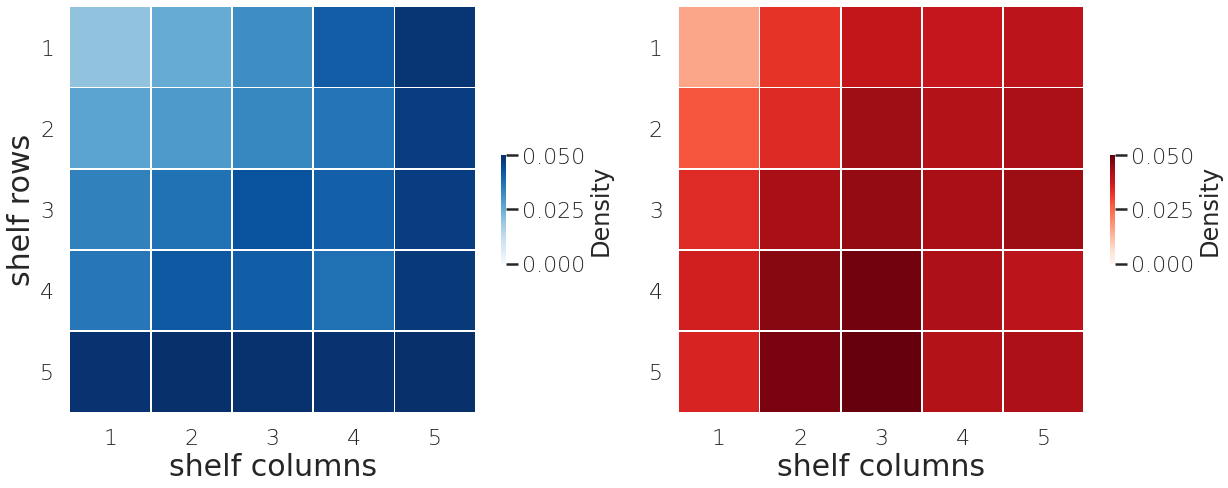

In [23]:
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

_, ax = plt.subplots(1,2,figsize=(20,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['pickup_x','pickup_y'], as_index=False)
    .pickup_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='pickup_y', columns = 'pickup_x', values='pickup_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Blues', square=True, ax=ax[0], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
ax[0].tick_params('y', labelrotation=0)
ax[0].set_xlabel('shelf columns', fontsize=30)
ax[0].set_ylabel('shelf rows', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['pickup_x','pickup_y'], as_index=False)
    .pickup_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='pickup_y', columns = 'pickup_x', values='pickup_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Reds', square=True, ax=ax[1], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('shelf columns', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_pickup_locations.pdf', quality=90, transparent=True)

drop_x,1,2,3,4,5
drop_y,,,,,
1,0.029990,0.045152,0.052982,0.047318,0.004998
2,0.047151,0.061480,0.066311,0.055815,0.007997
3,0.055148,0.070643,0.076974,0.056481,0.008830
4,0.051316,0.070310,0.072642,0.053815,0.006165
5,0.008164,0.015495,0.018827,0.013329,0.002666


drop_x,1,2,3,4,5
drop_y,,,,,
1,0.027458,0.043902,0.050447,0.047573,0.006226
2,0.044700,0.057152,0.064336,0.060504,0.008461
3,0.051564,0.063059,0.071999,0.061303,0.009898
4,0.050926,0.067209,0.074074,0.056833,0.010057
5,0.009419,0.020275,0.024425,0.014847,0.003352


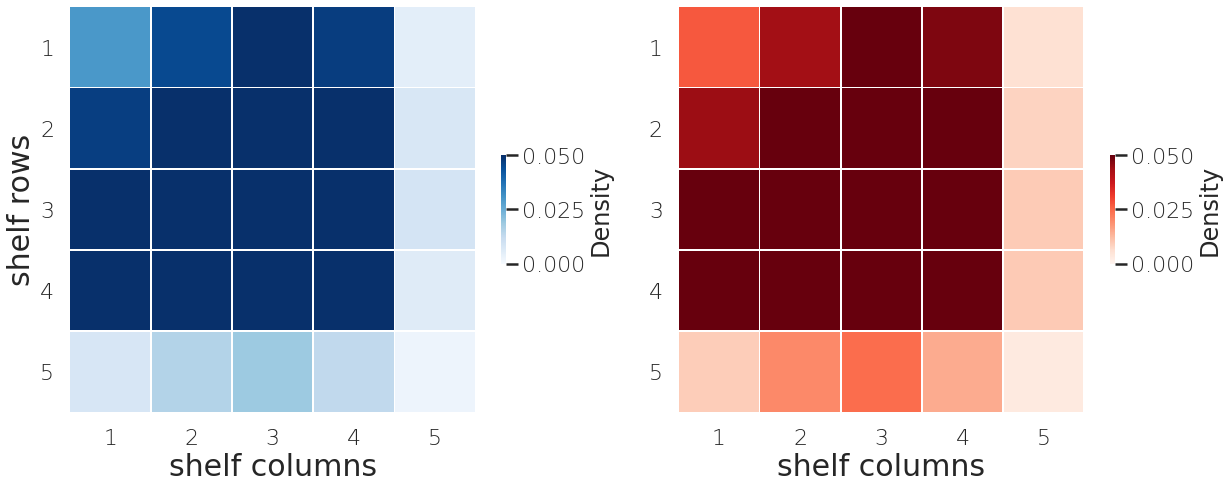

In [24]:
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})

_, ax = plt.subplots(1,2,figsize=(20,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['drop_x','drop_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='drop_y', columns = 'drop_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Blues', square=True, ax=ax[0], cbar_kws={"shrink": 0.2,  'label': 'Density'},)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
ax[0].tick_params('y', labelrotation=0)

ax[0].set_xlabel('shelf columns', fontsize=30)
ax[0].set_ylabel('shelf rows', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['drop_x','drop_y'], as_index=False)
    .drop_location
    .count()
)
# display(tmpdf)
tmpdf = tmpdf.pivot(index='drop_y', columns = 'drop_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
display(tmpdf)
sns.heatmap(tmpdf,vmin=0, vmax=0.05, linewidths=.6, cmap='Reds', square=True, ax=ax[1], cbar_kws={"shrink": 0.2,  'label': 'Density'})
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('shelf columns', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_drop_locations.pdf', quality=90, transparent=True)

(79, 3)

offset_x,-4,-3,-2,-1,0,1,2,3,4
offset_y,,,,,,,,,
-4,0.001417,0.002362,0.004487,0.011809,0.009211,0.007322,0.004251,0.004015,0.000472
-3,0.002834,0.006613,0.008739,0.018186,0.017714,0.011809,0.006613,0.003543,0.000709
-2,0.005668,0.010392,0.021256,0.030231,0.030468,0.026689,0.013462,0.007794,0.001653
-1,0.007558,0.020784,0.038262,0.068966,0.067076,0.038026,0.027870,0.008266,0.001653
0,0.008266,0.016769,0.034483,0.056212,0.000000,0.021493,0.011337,0.002834,0.001653
1,0.005196,0.014880,0.026925,0.046056,0.032593,0.021729,0.009211,0.003307,0.001181
2,0.006141,0.009920,0.018186,0.019839,0.017005,0.007322,0.004015,0.002126,0.000472
3,0.004960,0.006141,0.007794,0.008739,0.007322,0.002362,0.002362,0.001889,0.000472
4,0.000236,0.001181,0.002126,0.001653,0.002834,0.001181,0.000472,0.000945,0.000000


(78, 3)

offset_x,-4,-3,-2,-1,0,1,2,3,4
offset_y,,,,,,,,,
-4,0.000618,0.002103,0.002474,0.005566,0.006679,0.004824,0.003463,0.001979,0.000124
-3,0.001484,0.003587,0.008163,0.011626,0.014595,0.011750,0.006926,0.003463,0.000247
-2,0.003216,0.005813,0.013976,0.028695,0.032406,0.019295,0.011132,0.004700,0.000866
-1,0.004329,0.013111,0.029932,0.054422,0.070254,0.044032,0.018553,0.006679,0.000989
0,0.009276,0.014966,0.037353,0.080396,0.000000,0.055411,0.019666,0.009771,0.002721
1,0.003958,0.010390,0.023871,0.043661,0.053432,0.031045,0.010761,0.003958,0.000742
2,0.003958,0.007297,0.015090,0.022635,0.020161,0.011255,0.004824,0.001608,0.000371
3,0.002350,0.003711,0.005690,0.010513,0.008411,0.004205,0.002721,0.001484,0.000124
4,0.000124,0.000247,0.001732,0.001979,0.004205,0.001361,0.000495,0.000000,0.000000


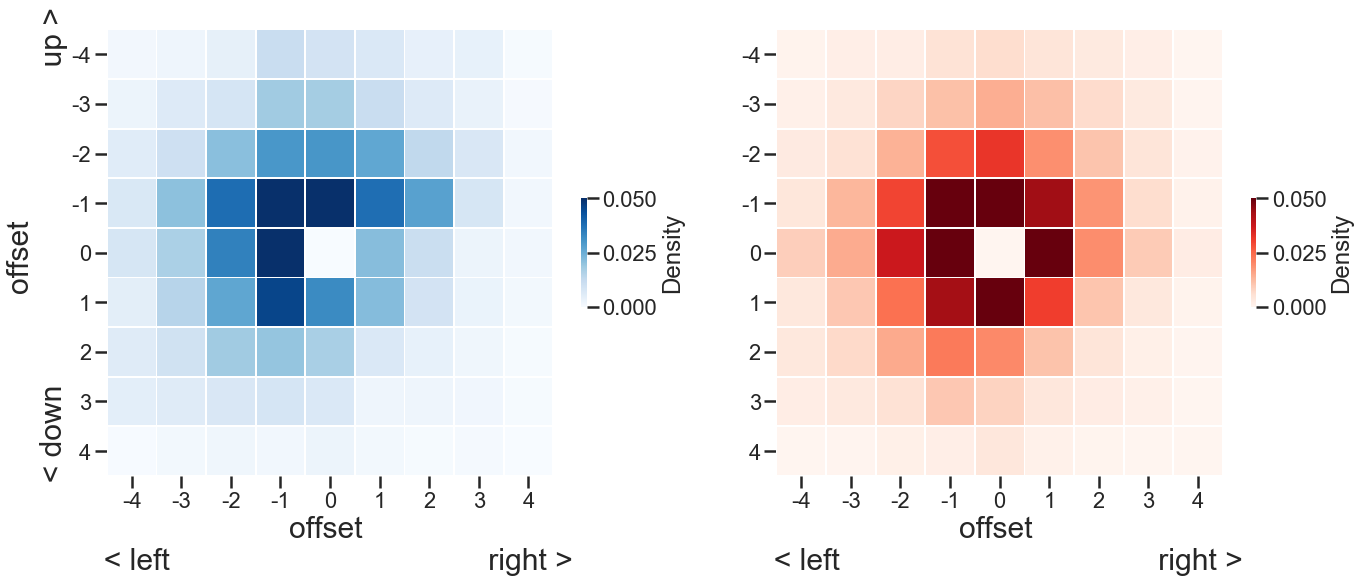

In [48]:
_, ax = plt.subplots(1,2,figsize=(22,10))
tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "easy"')
    .query('grasp_num >= 4')
    .groupby(['offset_x','offset_y'], as_index=False)
    .drop_location
    .count()
)
display(tmpdf.shape)
tmpdf = tmpdf.pivot(index='offset_y', columns = 'offset_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
tmpdf.fillna(0, inplace=True)
display(tmpdf)
sns.heatmap(
    tmpdf,vmin=0, vmax=0.05, 
    linewidths=.8, cmap='Blues', square=True, cbar_kws={"shrink": 0.2,  'label': 'Density'},
    ax=ax[0],
)
# ax[0].set_ylim(len(tmpdf)-0.05, -0.5)
# ax[0].set_yticks(rotation=0, fontsize=25) 
ax[0].tick_params('y', labelrotation=0)
ax[0].set_xlabel('offset \n  < left                                      right >', fontsize=30)
ax[0].set_ylabel('offset \n  < down                                      up >', fontsize=30)

tmpdf = (
    grasp_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['offset_x','offset_y'], as_index=False)
    .drop_location
    .count()
)
display(tmpdf.shape)
tmpdf = tmpdf.pivot(index='offset_y', columns = 'offset_x', values='drop_location')
tmpdf = tmpdf.divide(tmpdf.sum(axis=1).sum())
tmpdf.fillna(0, inplace=True)

display(tmpdf)
sns.heatmap(
    tmpdf,vmin=0, vmax=0.05, 
    linewidths=.8, cmap='Reds', square=True, cbar_kws={"shrink": 0.2,  'label': 'Density'},
    ax=ax[1],
)
# ax[1].set_ylim(len(tmpdf)-0.05, -0.5)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_xlabel('offset \n  < left                                      right >', fontsize=30)
ax[1].set_ylabel('', fontsize=30)


plt.savefig(PLOT_PATH+'/shelf_grasp_offsets.png', quality=90, transparent=True)

In [61]:
tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .groupby(['subject_id', 'trial_type', 'offset_x','offset_y'], as_index=False)
    .drop_location
    .count()
)
display(tmpdf)

,subject_id,trial_type,offset_x,offset_y,drop_location
0,2006.0,easy,-4,3,1
1,2006.0,easy,-3,-3,1
2,2006.0,easy,-3,-2,1
3,2006.0,easy,-3,0,1
4,2006.0,easy,-3,1,1
...,...,...,...,...,...
3851,2062.0,hard,2,2,2
3852,2062.0,hard,3,-4,1
3853,2062.0,hard,3,-3,1
3854,2062.0,hard,3,0,2


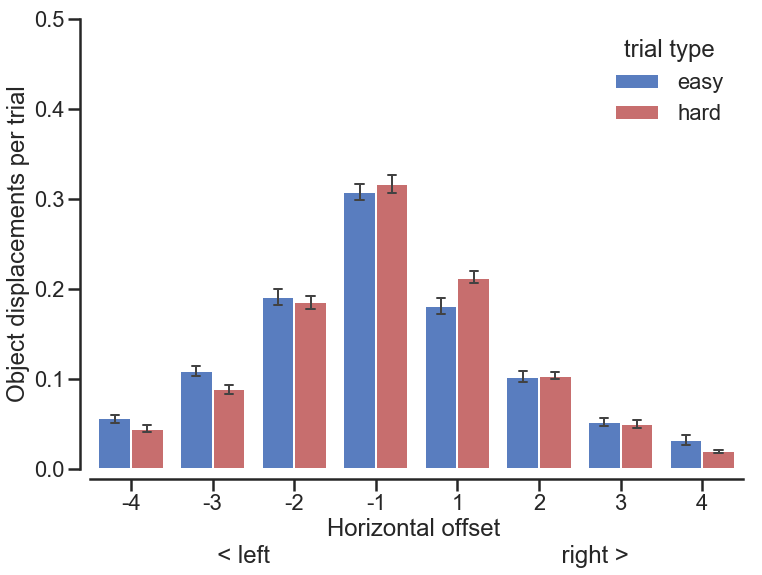

In [159]:

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'offset_x',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.barplot(
    data=tmpdf,
    x='offset_x',
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=68,
    capsize=.1,
    errwidth=2
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Object displacements per trial',
    xlabel='Horizontal offset \n  < left                                            right >',
)
ax.legend(frameon=False, title='trial type')
sns.despine(offset=10)

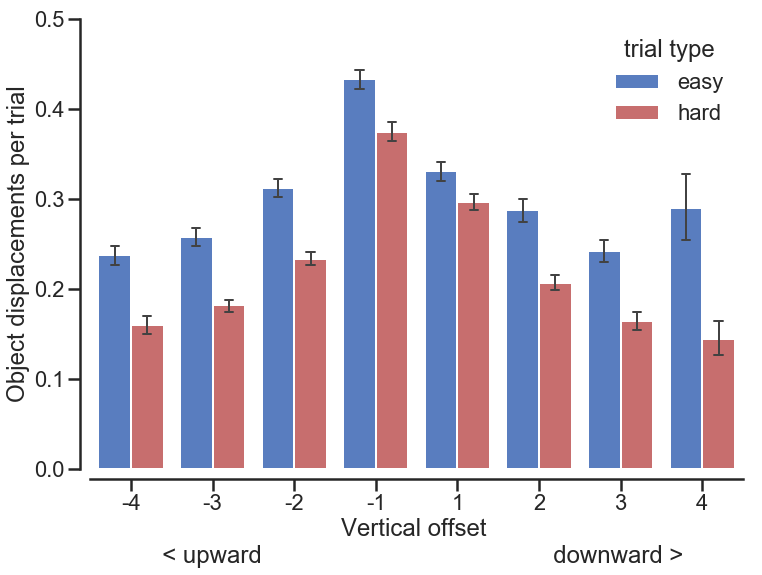

In [145]:

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'trial_num', 'offset_y',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1, 2,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.barplot(
    data=tmpdf,
    x='offset_y',
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=68,
    capsize=.1,
    errwidth=2
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Object displacements per trial',
    xlabel='Vertical offset \n  < upward                                            downward >',
)
ax.legend(frameon=False, title='trial type')
sns.despine(offset=10)

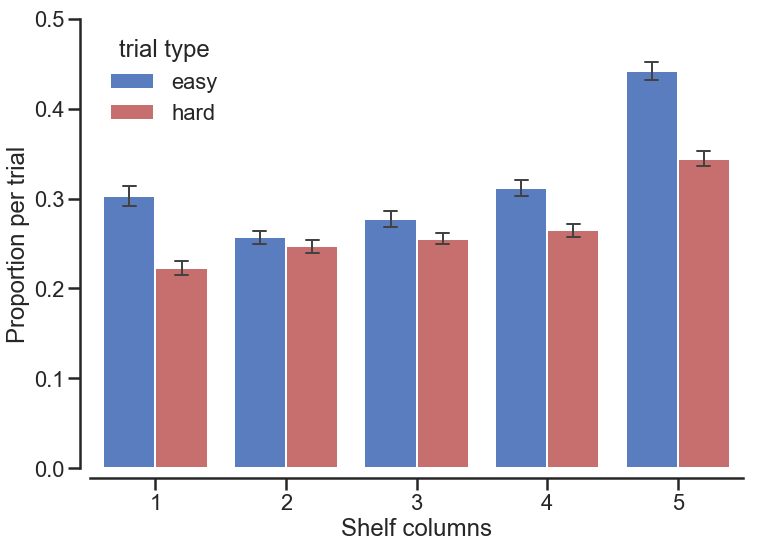

In [153]:

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'trial_num', 'pickup_x',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1, 2,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.barplot(
    data=tmpdf.sort_values(by='pickup_x'),
    x='pickup_x',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=68,
    capsize=.1,
    errwidth=2
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Proportion per trial',
    xlabel='Shelf columns',
)
ax.legend(frameon=False, title='trial type')
sns.despine(offset=10)

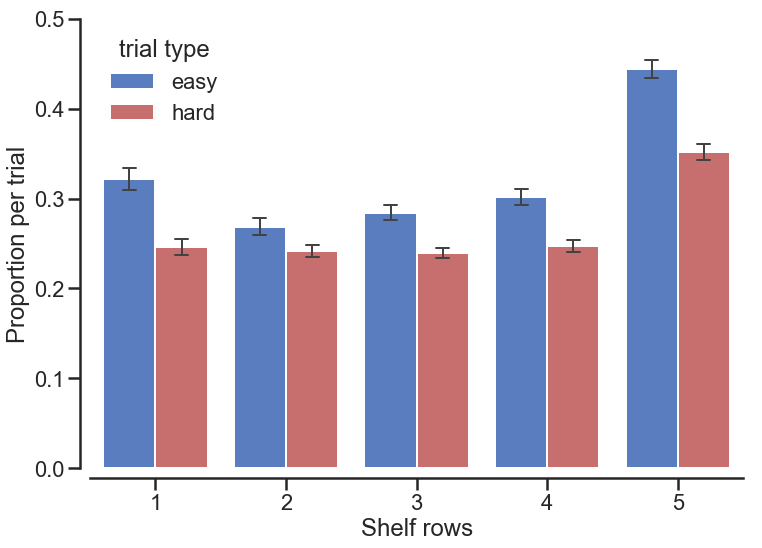

In [155]:

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'trial_num', 'pickup_y',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1, 2,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.barplot(
    data=tmpdf.sort_values(by='pickup_y'),
    x='pickup_y',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=68,
    capsize=.1,
    errwidth=2
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Proportion per trial',
    xlabel='Shelf rows',
)
ax.legend(frameon=False, title='trial type')
sns.despine(offset=10)

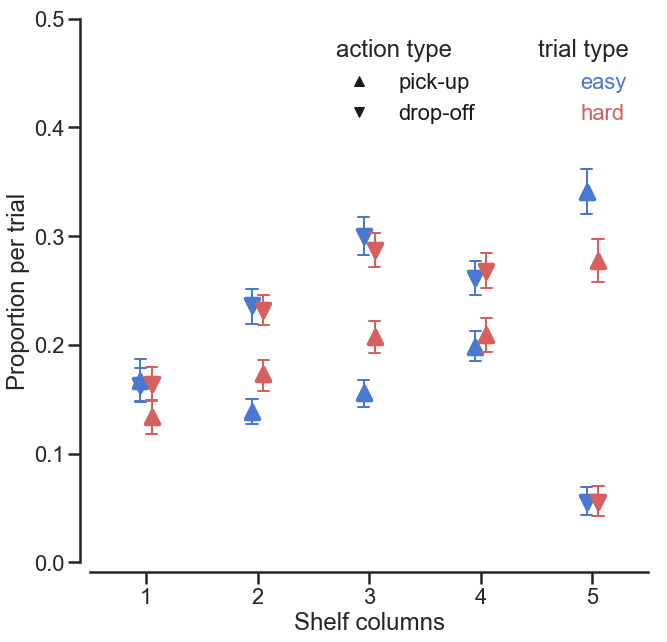

In [236]:
_, ax = plt.subplots(figsize=(10,10))

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'pickup_x',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.pointplot(
    data=tmpdf.sort_values(by='pickup_x'),
    x='pickup_x',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=95,
    capsize=.1,
    errwidth=2,
    dodge=0.1,
    markers='^',
    legend=False,
    linewidth=0.5,
    join=False
)
tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'drop_x',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.pointplot(
    data=tmpdf.sort_values(by='drop_x'),
    x='drop_x',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=95,
    capsize=.1,
    errwidth=2,
    dodge=0.1,
#     linestyles=":",
    lw=1,
    markers='v',
    markeredgecolor='k',
    join=False,
    alpha=0.7,
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Proportion per trial',
    xlabel='Shelf columns',
)
ax.legend(frameon=False, title='trial type')
pickup = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, label='pick-up')
dropoff = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                          markersize=10, label='drop-off')
easy = mlines.Line2D([], [],marker='None', linestyle='None',
                          label='easy')
hard = mlines.Line2D([], [], marker='None', linestyle='None',
                          label='hard')
leg = ax.legend(
    frameon=False, 
    title='action type             trial type', 
    handles=[pickup, dropoff, easy, hard ],
    ncol=2
)
for color,text in zip(['k', 'k', 'b', 'r'],leg.get_texts()):
    text.set_color(color)

sns.despine(offset=10)

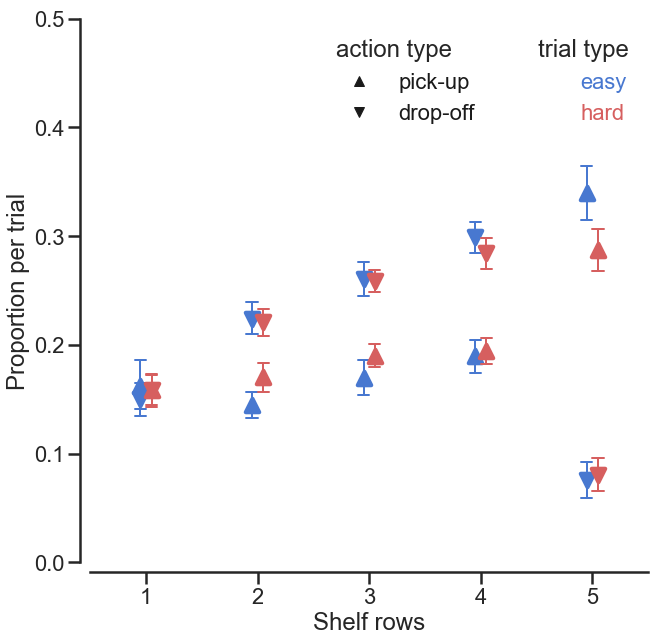

In [235]:
_, ax = plt.subplots(figsize=(10,10))

tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'pickup_y',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.pointplot(
    data=tmpdf.sort_values(by='pickup_y'),
    x='pickup_y',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=95,
    capsize=.1,
    errwidth=2,
    dodge=0.1,
    markers='^',
    legend=False,
    linewidth=0.5,
    join=False
)
tmpdf = (
    grasp_df
    .reset_index()
    .query('grasp_num >= 4')
    .query('offset_x != 0 and offset_y != 0')
    .groupby(
        ['subject_id', 'trial_type', 'drop_y',], 
#         as_index=False
    )
    .drop_location
    .count()
#     .rename('count')
)
tmpdf = (
    tmpdf
    .groupby(level=[0, 1,])
    .apply(lambda x: x/x.sum())
    .reset_index(name='proportion')
)
# display(tmpdf)
ax = sns.pointplot(
    data=tmpdf.sort_values(by='drop_y'),
    x='drop_y',
#     order=[1,2,3,4,5],
    y='proportion',
    hue='trial_type',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    ci=95,
    capsize=.1,
    errwidth=2,
    dodge=0.1,
#     linestyles=":",
    lw=1,
    markers='v',
    markeredgecolor='k',
    join=False,
    alpha=0.7,
)

ax.set(
    ylim=(0,.5),
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylabel='Proportion per trial',
    xlabel='Shelf rows',
)
ax.legend(frameon=False, title='trial type')
pickup = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, label='pick-up')
dropoff = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                          markersize=10, label='drop-off')
easy = mlines.Line2D([], [],marker='None', linestyle='None',
                          label='easy')
hard = mlines.Line2D([], [], marker='None', linestyle='None',
                          label='hard')
leg = ax.legend(
    frameon=False, 
    title='action type             trial type', 
    handles=[pickup, dropoff, easy, hard ],
    ncol=2
)
for color,text in zip(['k', 'k', 'b', 'r'],leg.get_texts()):
    text.set_color(color)

sns.despine(offset=10)